In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import Lasso, Ridge
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Paths
folder = r'C:\Users\skova'
X_train_path = folder + r'\X_train.csv'
Y_train_path = folder + r'\Y_train.csv'
X_test_path  = folder + r'\X_test.csv'
Y_test_path  = folder + r'\Y_test.csv'

In [2]:
# Load datasets
X_train = pd.read_csv(X_train_path)
y_train = pd.read_csv(Y_train_path).squeeze()
X_test = pd.read_csv(X_test_path)
y_test = pd.read_csv(Y_test_path).squeeze()

# Engineered features expected by model
required_features = ['Low_SBP', 'High_HR', 'Error_group', 'KTAS_RN', 'KTAS_expert',
                     'Pain_Injury', 'Age_KTAS', 'Low_Saturation', 'Diagnosis in ED',
                     'Crowding_Index', 'Disposition', 'KTAS duration_min']

# Fill missing columns
for col in required_features:
    if col not in X_train.columns:
        X_train[col] = 0
    if col not in X_test.columns:
        X_test[col] = 0

# Ensure same column order
X_train = X_train[sorted(X_train.columns)]
X_test  = X_test[sorted(X_train.columns)]

In [3]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [4]:
# Tree-based
rf = RandomForestRegressor(n_estimators=200, max_depth=10, random_state=42)
xgb = XGBRegressor(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)

# Linear models
lasso = Lasso(alpha=0.01, max_iter=10000)
ridge = Ridge(alpha=1.0, max_iter=10000)

In [5]:
estimators = [
    ('rf', rf),
    ('xgb', xgb),
    ('lasso', lasso),
    ('ridge', ridge)
]

stacked_model = StackingRegressor(
    estimators=estimators,
    final_estimator=Ridge(),  # meta-model
    n_jobs=-1
)

In [6]:
stacked_model.fit(X_train_scaled, y_train)

,"estimators estimators: list of (str, estimator)Base estimators which will be stacked together. Each element of thelist is defined as a tuple of string (i.e. name) and an estimatorinstance. An estimator can be set to 'drop' using `set_params`.","[('rf', ...), ('xgb', ...), ...]"
,"final_estimator final_estimator: estimator, default=NoneA regressor which will be used to combine the base estimators.The default regressor is a :class:`~sklearn.linear_model.RidgeCV`.",Ridge()
,"cv cv: int, cross-validation generator, iterable, or ""prefit"", default=NoneDetermines the cross-validation splitting strategy used in`cross_val_predict` to train `final_estimator`. Possible inputs forcv are:* None, to use the default 5-fold cross validation,* integer, to specify the number of folds in a (Stratified) KFold,* An object to be used as a cross-validation generator,* An iterable yielding train, test splits,* `""prefit""`, to assume the `estimators` are prefit. In this case, the estimators will not be refitted.For integer/None inputs, if the estimator is a classifier and y iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used.In all other cases, :class:`~sklearn.model_selection.KFold` is used.These splitters are instantiated with `shuffle=False` so the splitswill be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.If ""prefit"" is passed, it is assumed that all `estimators` havebeen fitted already. The `final_estimator_` is trained on the `estimators`predictions on the full training set and are **not** cross validatedpredictions. Please note that if the models have been trained on the samedata to train the stacking model, there is a very high risk of overfitting... versionadded:: 1.1 The 'prefit' option was added in 1.1.. note:: A larger number of split will provide no benefits if the number of training samples is large enough. Indeed, the training time will increase. ``cv`` is not used for model evaluation but for prediction.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for `fit` of all `estimators`.`None` means 1 unless in a `joblib.parallel_backend` context. -1 meansusing all processors. See :term:`Glossary ` for more details.",-1
,"passthrough passthrough: bool, default=FalseWhen False, only the predictions of estimators will be used astraining data for `final_estimator`. When True, the`final_estimator` is trained on the predictions as well as theoriginal training data.",False
,"verbose verbose: int, default=0Verbosity level.",0
,"n_estimators n_estimators: int, default=100The number of trees in the forest... versionchanged:: 0.22 The default value of ``n_estimators`` changed from 10 to 100 in 0.22.",200
,"criterion criterion: {""squared_error"", ""absolute_error"", ""friedman_mse"", ""poisson""}, default=""squared_error""The function to measure the quality of a split. Supported criteriaare ""squared_error"" for the mean squared error, which is equal tovariance reduction as feature selection criterion and minimizes the L2loss using the mean of each terminal node, ""friedman_mse"", which usesmean squared error with Friedman's improvement score for potentialsplits, ""absolute_error"" for the mean absolute error, which minimizesthe L1 loss using the median of each terminal node, and ""poisson"" whichuses reduction in Poisson deviance to find splits.Training using ""absolute_error"" is significantly slowerthan when using ""squared_error""... versionadded:: 0.18 Mean Absolute Error (MAE) criterion... versionadded:: 1.0 Poisson criterion.",'squared_error'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",10
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as 

In [7]:
def evaluate(y_true, y_pred, name="Model"):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{name} Metrics:\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}\nR²: {r2:.4f}\n")
    return rmse, mae, r2

# Predict
y_pred = stacked_model.predict(X_test_scaled)
evaluate(y_test, y_pred, "Stacked Ensemble Improved Model")

Stacked Ensemble Improved Model Metrics:
RMSE: 0.8773
MAE: 0.6916
R²: 0.3577



(np.float64(0.8773149791878428), 0.6915507948202203, 0.3576525685259987)

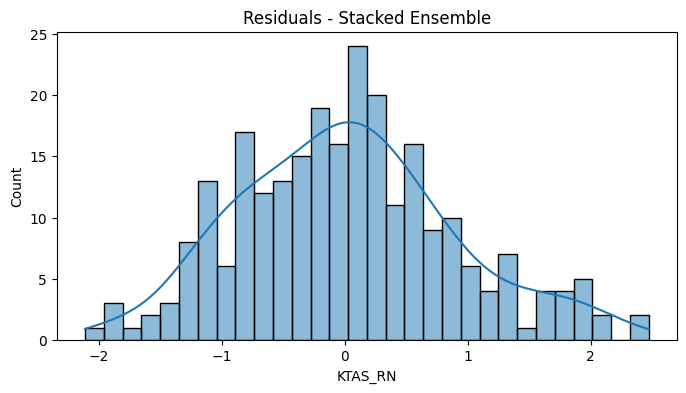

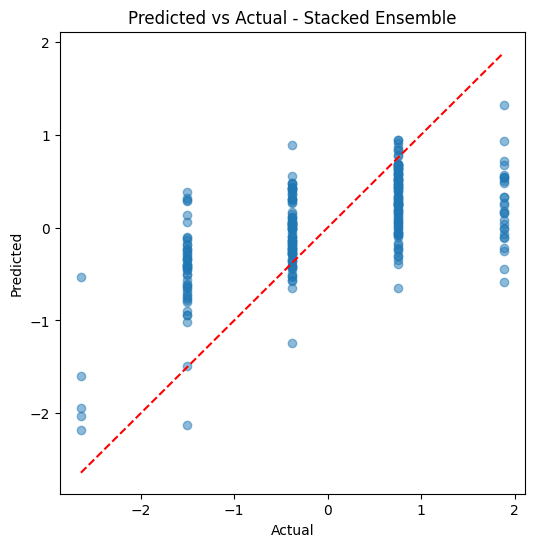

In [8]:
residuals = y_test - y_pred

plt.figure(figsize=(8,4))
sns.histplot(residuals, bins=30, kde=True)
plt.title("Residuals - Stacked Ensemble")
plt.show()

plt.figure(figsize=(6,6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual - Stacked Ensemble")
plt.show()

In [9]:
joblib.dump(stacked_model, folder + r'\stacked_model_improved.joblib')
joblib.dump(scaler, folder + r'\scaler_improved.joblib')

['C:\\Users\\skova\\scaler_improved.joblib']